# Load Environment

In [100]:
%load_ext autoreload
%autoreload 2
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format='svg'
import seaborn
seaborn.reset_orig()
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 4

import itertools
import numpy as np
from numpy import inf
from numpy.linalg import norm
from optalg.opt_solver import *
import scipy.io # to read matlab files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

In [2]:
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import mppfnet
import gridopt
import pfnet
import multiprocessing

# Load Network
Construct multi-period network and load topology

In [3]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

## Set Prices
Load EEX prices from a `.mat` file and set the bus prices accordingly.

In [4]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]])
mp.set_prices(eex_prices)

## Set Load Profiles
Read load profiles form a `.csv` generated with [ALPG](https://github.com/GENETX/alpg).

In [5]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

## Set Solar Profiles
Generates and sets solar profiles from [PVWatts](http://pvwatts.nrel.gov/)

In [6]:
mp.generate_solar_profiles()

# Optimization Problem

Define bus voltage angles as variables (except the slack bus)

In [7]:
mp.set_flags(pfnet.OBJ_BUS, pfnet.FLAG_VARS, pfnet.BUS_PROP_NOT_SLACK, pfnet.BUS_VAR_VANG)

Set batteries power $P$ and energy $E$ as variables

In [8]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)

Set generator powers as variables

In [9]:
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_NOT_SLACK,pfnet.GEN_VAR_P)

Set the active power at the slack bus as a variable

In [10]:
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_SLACK,pfnet.GEN_VAR_P)

Set the active power of the generators as an optimization variable

In [11]:
mp.set_flags(pfnet.OBJ_GEN,pfnet.FLAG_BOUNDED,pfnet.GEN_PROP_ANY,pfnet.GEN_VAR_P)

Set the power $P$ and the energy $E$ of the battery as bounded

In [12]:
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

## Construct the optimization problem

In [13]:
p = MPProblem(mp)

Add the netcon cost function:
$$f(x) = c_e \cdot (l + p_c + p_d - r)$$

In [14]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

Generator Bounds

In [15]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)

DC Power Flow

In [16]:
p.add_constraint(pfnet.CONSTR_TYPE_DCPF)

Battery Dynamics Constraints

In [17]:
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN)

Analyse the Problem, set the initial point and evaluate the initial point $x_0$

In [18]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

Show some information about the network:

In [19]:
mp.show_components()

Network Components
-----------------------------
timesteps:           : 24
------- per timestep --------
buses:               : 31
   slack:            : 1
   reg by gen:       : 1
   reg by tran:      : 0
   reg by shunt:     : 0
shunts:              : 0
   fixed:            : 0
   switched v:       : 0
branches:            : 30
   lines:            : 29
   fixed trans:      : 1
   phase shifters    : 0
   tap changers v    : 0
   tap changers Q    : 0
generators:          : 1
   slack:            : 1
   reg:              : 1
   P adjust          : 1
loads:               : 19
   P adjust:         : 0
vargens:             : 2
batteries:           : 3


# Construct optimization problem for linear solver

In [20]:
from scipy.sparse import triu

In [21]:
Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x
g = gx / mp.base_power
H = Hx / mp.base_power
A = p.A
b = p.b
l = p.l
u = p.u
x = p.x

In [22]:
problem = QuadProblem(H, g, A, b, l, u, x=x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': False, 'tol': 1e-8, 'maxiter': 10000})
problem.show()

Solve Optimization Problem

In [23]:
solver.solve(problem)
print(solver.get_status())


Solver: IQP
-----------
iter    phi      fmax      gmax       cu       cl       s    
 0  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  0.0e+00 
 1  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  3.0e-06 
 2  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  1.6e-05 
 3  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  1.2e-05 
 4  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  1.9e-05 
 5  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  3.1e-05 
 6  2.25e+04  5.74e+03  1.15e+04  1.0e+01  1.0e+01  2.7e-05 
 7  2.25e+04  5.73e+03  1.15e+04  1.0e+01  1.0e+01  2.5e-04 
 8  2.24e+04  5.73e+03  1.15e+04  1.0e+01  1.0e+01  3.9e-04 
 9  2.22e+04  5.70e+03  1.14e+04  9.9e+00  9.9e+00  5.9e-03 
10  2.18e+04  5.64e+03  1.13e+04  9.8e+00  9.8e+00  1.1e-02 
11  2.07e+04  5.49e+03  1.10e+04  9.6e+00  9.6e+00  2.5e-02 
12  2.07e+04  5.49e+03  1.10e+04  9.6e+00  9.6e+00  3.1e-05 
13  2.07e+04  5.49e+03  1.10e+04  9.6e+00  9.6e+00  2.8e-05 
14  2.07e+04  5.49e+03  1.10e+04  9.6e+00  9.6e+00  5.0e-05

Store Solver Result

In [24]:
mp.set_var_values(solver.get_primal_variables())
mp.update_properties()

# Output

In [25]:
%aimport pfvis

## Battery SOC

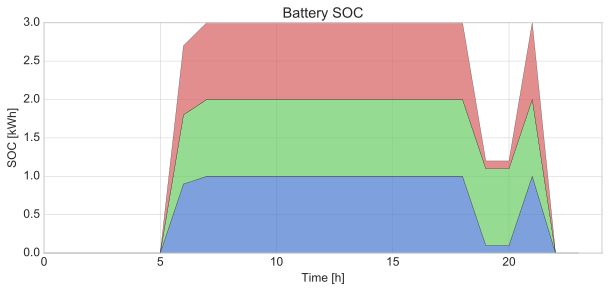

In [26]:
pfvis.plot_battery_soc(mp)

## Battery Power

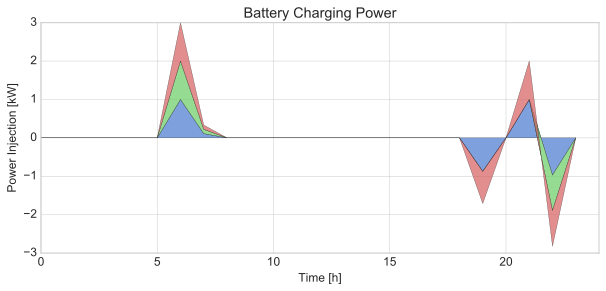

In [27]:
pfvis.plot_battery_power(mp)

## Energy Price

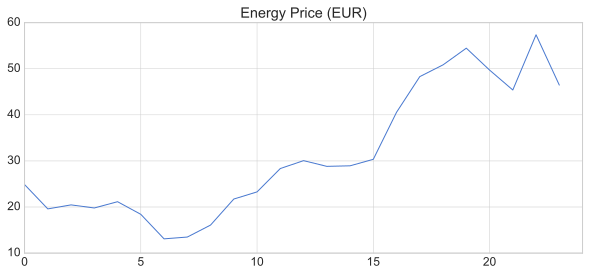

In [28]:
pfvis.plot_energy_price(mp)

## Load Power

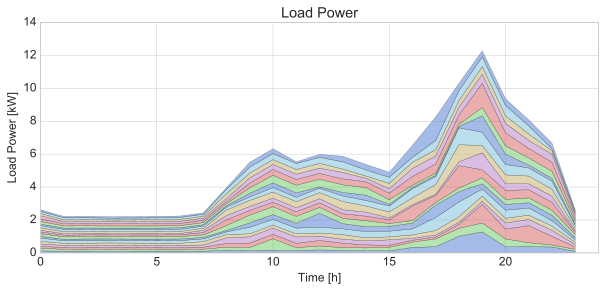

In [29]:
pfvis.plot_load_power(mp)

## Injection by renewable Generation

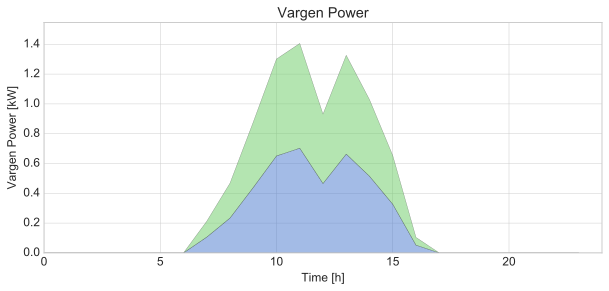

In [30]:
pfvis.plot_vargen_injection(mp)

## Network Graph

In [31]:
#g = pfnet.Graph(mp.networks[0])
#for bus in mp.networks[0].buses:
#    g.set_node_property(bus,b"label",str(bus.number).encode('UTF-8'))
#    g.set_node_property(bus,b"color",("red" if len(bus.bats) else "black").encode('UTF-8'))

#g.set_layout()    
#g.view(inline=True)

# Distributed Approach

In [32]:
prob = p.problems[0]
prob.analyze()
constraint = prob.constraints[1]
constraint.A.shape

(31, 40)

## Solve Benchmark Centralized QP Problem

In [33]:
nx = A.shape[1]
nc = A.shape[0]

print("Shape of A: {0}".format(A.shape))
print("Shape of b: {0}".format(b.shape))
print("Shape of g: {0}".format(g.shape))
print("Shape of H: {0}".format(H.shape))
print("Shape of l: {0}".format(l.shape))
print("Shape of u: {0}".format(u.shape))

Shape of A: (816, 960)
Shape of b: (816,)
Shape of g: (960,)
Shape of H: (960, 960)
Shape of l: (960,)
Shape of u: (960,)


Set the initial point $x_0$ to be all zeros (flat start)

In [35]:
x = np.zeros((nx,))

Construct the quadratic problem from $H, g, A, b, l$ and $u$ matricies constructed before

In [36]:
problem = QuadProblem(H, g, A, b, l, u, x=x)
solver = OptSolverIQP()
solver.set_parameters({'quiet': True, 'tol': 1e-4})

Solve the optimization problem and store the primal solution as $x^*$ and the optimal objective value as $p^*$

In [37]:
solver.solve(problem)
xstar = solver.get_primal_variables().copy()
pstar = np.dot(g,xstar)
print("Optimal objective value: {0:.2E} ".format(pstar))
#print(solver.get_dual_variables()[0])
#print(solver.get_primal_variables())

Optimal objective value: -1.20E+03 


Construct the decoupled subproblem with the DC power balance relaxed in the objective:
    
$$
    \begin{align}\min &&& f(x) \\
    s.t. & && A x = b \\
     & && x_1, \ldots x_n \in \mathcal X_1, \ldots \mathcal X_n
    \end{align}
    $$

In [38]:
import cvxpy
from scipy.sparse import triu,coo_matrix,bmat,eye

# construct decoupled problem
# dc power flow constraints
A = scipy.sparse.block_diag([prob.constraints[1].A for prob in p.problems.values()])
b = np.hstack([prob.constraints[1].b for prob in p.problems.values()])
print("Shape of A: {0}".format(A.shape))
print("Shape of b: {0}".format(b.shape))

# battery dynamics
Abat = scipy.sparse.vstack([p.get_battery_A(battery) for battery in p.net.get_network().batteries])
bbat = np.hstack([p.get_battery_b(battery) for battery in p.net.get_network().batteries])
print("Shape of Abat: {0}".format(Abat.shape))
print("Shape of bbat: {0}".format(bbat.shape))
print("Shape of x: {0}".format(x.shape))

Shape of A: (744, 960)
Shape of b: (744,)
Shape of Abat: (72, 960)
Shape of bbat: (72,)
Shape of x: (960,)


## Dual Gradient Ascent

Initial Values:

In [40]:
lam = np.zeros(A.shape[0])  # really poor dual initial point
x = np.zeros((nx,)) # poor guess on the initial point

Parameters:

In [41]:
tol = 1e-5
mu = 1

Initial Points:

In [42]:
lam = np.zeros(A.shape[0])  # really poor dual initial point
x = np.zeros((nx,)) # poor guess on the initial point

In [50]:
print("Solver: Dual Gradient")
print("----------------------------")
print("it  obj         alpha         lmin           lmax         dL/dl         deltax       error")
print("in  {1:.2E}      {2:.2E}         {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(0, g.dot(x),  np.NaN, np.min(lam), np.max(lam),  norm(A*x -b), norm(x), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))


for iteration in range(1, 100):
    xprev = x.copy()
    
    alpha = 1 / (norm(b-A*x)* (iteration + 1)) 

    # Primal update
    solver = OptSolverIQP()
    
    # Projection on the set
    QPproblem = QuadProblem(H+mu*A.T*A, g-A.T*lam-mu*A.T*b, Abat,bbat,l,u,x=x)
    solver.set_parameters({'quiet':True, 'tol' : 1e-4})
    solver.solve(QPproblem)
    x = solver.get_primal_variables()
    
    # Dual update
    lam += alpha * (b - A*x)
    
    # Print information
    if iteration:
        print("{0}  {1:.2E}  {2:.2E}      {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(iteration, g.dot(x),  alpha, np.min(lam), np.max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))

    # Check for convergence
    if norm(A*x -b) < tol and np.abs(np.dot(g,x)-pstar)/np.abs(pstar) < tol:
        print("Converged")
        print("*  {1:.2E}  {2:.2E}      {3:.2E}      {4:.2E}     {5:.2E}      {6:.2E}     {7:.2E}".format(iteration, g.dot(x),  alpha, np.min(lam), np.max(lam),  norm(A*x -b), norm(x - xprev), np.abs(np.dot(g,x)-pstar)/np.abs(pstar)))
        break
        

Solver: Dual Gradient
----------------------------
it  obj         alpha         lmin           lmax         dL/dl         deltax       error
in  0.00E+00      NAN         0.00E+00      0.00E+00     7.61E-01      0.00E+00     1.00E+00
1  -1.20E+03  6.57E-01      -1.12E-10      2.99E-09     8.61E-08      3.02E+00     5.73E-13
Converged
*  -1.20E+03  6.57E-01      -1.12E-10      2.99E-09     8.61E-08      3.02E+00     5.73E-13


Plot a bar plot of $x$

In [51]:
mp.set_var_values(solver.get_primal_variables())

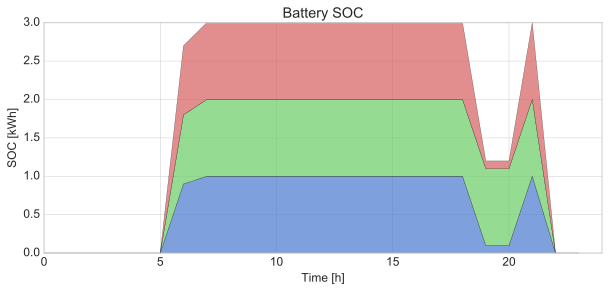

In [52]:
pfvis.plot_battery_soc(mp)

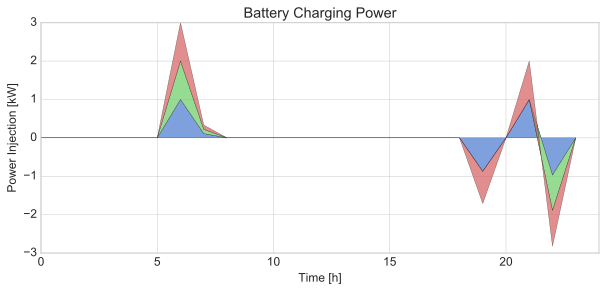

In [53]:
pfvis.plot_battery_power(mp)

## Primal / Dual Gradient Method

# Required Communication

## Analysis for the problem without batteries

Since we use the augmented Lagrangian we need additional communication with not only the neighbouring nodes. To determine the additional communication requirements we inspect the structure of $A$.

We note that $A$ represents the DC power balance constraints and that $A$ is a Laplacian Matrix. For the following derivation we therefore denote the matrix containing the power blance as $L$ (to indicate its laplacian structure) and the adjacency matrix of the underlying graph $\hat A$ (not to be confused with $A$).

The Laplacian can be written as [[1]](http://www.sciencedirect.com/science/article/pii/0024379594904863):

$$L = D_{o} - \hat A$$

where $D_{o} = \text{diag} (d_{o})$ with $d_{o}$ being the vector of nodal out degrees.


Using this, we can write $A^\top A = A A$ (due to symmetry) as:
$$L L = (D_{o} D_{o} - D_{o} \hat A - \hat A D_{o} + \hat A \hat A$$
Using the diagonal structure of $D_o$ this simplifies to:
$$ L L = \text{diag} (d_o^2) - 2 \text{diag} (d_o) \hat A + \hat A \hat A$$
Inspecting this, we can see that the first term requires only local values and the second term is only a scaling of the values of the adjacent nodes.
$\hat A \hat A$ is the squared adjacency matrix, hence it is nonzero at $(i, j)$ if and only if $j$ is reachable from $i$ with 2 steps.

In [56]:
L = prob.constraints[1].A.tocsr()[:, :31]
do = np.array([len(bus.branches) for bus in mp.get_network().buses])
Do = np.diag(do)
Ahat = np.diag(do) - L
LL = Do * Do - 2 * Do * Ahat + Ahat * Ahat

In [58]:
np.count_nonzero(Ahat) - Ahat.shape[0] 

59

Additional communication exchanges:

In [59]:
np.count_nonzero(LL) - Ahat.shape[0] 

137

In [60]:
import networkx as nx
from networkx.readwrite import json_graph
import json
g = nx.from_numpy_matrix(Ahat)
data = json_graph.node_link_data(g)
s = json.dumps(data)
with open('graph.json', 'w') as f:
    f.write(s)

## Analysis for the problem with batteries

In [61]:
prob.constraints[1].A.tocsr().nnz

96

In [62]:
(prob.constraints[1].A.T * prob.constraints[1].A).nnz

225

For the problem with batteries, we also need the net consumption of all neighbouring nodes when using the augmented Lagrangian.

# ADMM

For ADMM we use the augmented Lagrangian:
$$L(x, \lambda) = f(x) - \lambda (A x - b) + \frac{\rho}{2} \norm{A x - b}^2_2$$
This can be seperated in $N$ subproblems (for $N$ buses) with $i \in \{ 1, \ldots, N\}$:
$$L(x, \lambda) = \sum_i f(x_i) - \sum_i \lambda A_i x_i - \lambda b + \frac{\rho}{2} \norm{\sum_i A_i x_i - b}^2_2$$

In [63]:
Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x
g = gx / mp.base_power
H = Hx / mp.base_power
A = p.A
b = p.b
l = p.l
u = p.u
x = p.x

## Projection Matrices

We construct projection matrices for the following projections:

$P_i$ (`p_mats`): Projection that extracts the variables asssociated with bus $i$ from the global state vector $x$

$P_{a, i}$ (`p_ang`): Projection that extracts the angles from the local state vector $\bar x_i$

$P_{pb, i}$ (`p_pb`): Projection that extracts the power balance for bus $i$ from the matrix of DC power flow constraints $A$

$P_{z, i}$ (`p_z`): Projection that extracts all angles bus $i$ is adjacent to (including itself) from the global state vector $z$

In [64]:
(sim_p_mats, sim_p_ang, sim_p_x) = mp.get_projection_matrix(mp.get_network().buses)
sim_p_pb = mp.get_power_balance_projection()
sim_p_z = mp.get_coupling_ang_projection()

In [65]:
net = mp.get_network()

Create the cost vectors for the individual subproblems $g_i \forall i$

In [66]:
g_mats = {bus.index: sim_p_mats[bus.index] * g for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

Create the lower and upper bounds $u_i, l_i$ for all buses $i \in \{1, \ldots n\}$

In [67]:
l_mats = {bus.index: sim_p_mats[bus.index] * l for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}
u_mats = {bus.index: sim_p_mats[bus.index] * u for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

Create the constraints that represent the battery dynamics $A_{bat, i} \bar x_i = b_{bat, i}$

In [70]:
net = mp.get_network()
a_bats = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        a_bats[bus.index] = scipy.sparse.vstack([p.get_battery_A(bat) * sim_p_mats[bus.index].T for bat in bus.bats])
    else:
        a_bats[bus.index] = scipy.sparse.coo_matrix(([], ([], [])), shape=(0, sim_p_mats[bus.index].T.shape[1]))
b_bats = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        b_bats[bus.index] = np.hstack([p.get_battery_b(bat) for bat in bus.bats])   
    else:
        b_bats[bus.index] = np.array([])

Create the DC power flow constraints for each bus:
$$P_{pb, i} A P_{i}^\top = A_{pb, i} \bar x_i = b_{pb, i}$$

In [71]:
A = scipy.sparse.block_diag([prob.constraints[1].A for prob in p.problems.values()])
b = np.hstack([prob.constraints[1].b for prob in p.problems.values()])
a_pb = [sim_p_pb[bus.index] * A * sim_p_mats[bus.index].T for bus in filter(lambda bus: (not bus.is_slack()), net.buses) ]
b_pb = [sim_p_pb[bus.index] * b for bus in filter(lambda bus: (not bus.is_slack()), net.buses) ]

Merge the battery dynamic and DC power flow constraints to a common (local) equality constraint:
$$A_i \bar x_i = b_i$$

In [72]:
a_const, b_const = dict(), dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        a_const[bus.index] = scipy.sparse.vstack([a_bats[bus.index], a_pb[bus.index]])
        b_const[bus.index] = np.hstack([b_bats[bus.index], b_pb[bus.index]])
    else: 
        a_const[bus.index] = a_pb[bus.index]
        b_const[bus.index] = b_pb[bus.index]


Set the zero vector as an initial point:
$$\bar x_i = 0 \quad \forall i$$

$\bar x_i$ must have the appropriate size and captures all local variables and estimates of the angles of the adjacent buses $\Omega_i$

In [73]:
x_local = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    variables = g_mats[bus.index].shape[0]
    x_local[bus.index] =  np.random.randn(variables)    
    assert(x_local[bus.index].shape == (variables, ))

## Check Problem with CVXPY

In [74]:
import cvxpy

Initialize Variables

In [75]:
c_x_local = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    variables = g_mats[bus.index].shape[0]
    c_x_local[bus.index] =  cvxpy.Variable(variables)
c_z = cvxpy.Variable((net.num_buses-1) * mp.timesteps)

Create objective

In [76]:
obj = 0.0
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    obj += g_mats[bus.index] * c_x_local[bus.index]

Create constraints

In [77]:
constraints = []
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    constraints += [a_const[bus.index] * c_x_local[bus.index] == b_const[bus.index]]
    constraints += [l_mats[bus.index] <= c_x_local[bus.index]] 
    constraints += [c_x_local[bus.index] <= u_mats[bus.index]]     
    constraints += [sim_p_z[bus.index] * c_z == sim_p_ang[bus.index] * c_x_local[bus.index]]

Solve ADMM-style problem in a centralized way (to check that the problem is created correctly)

In [79]:
objective = cvxpy.Minimize(obj)
prob = cvxpy.Problem(objective, constraints)
prob.solve(verbose=True)  # Returns the optimal value.
prob.status


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.491e+04  -1.379e+09  +1e+09  2e-03  5e-11  1e+00  3e+05    ---    ---    1  2  - |  -  - 
 1  +4.006e+04  -1.324e+09  +1e+09  2e-03  5e-11  5e+03  3e+05  0.0568  3e-01   1  1  0 |  0  0
 2  -3.237e+03  -2.579e+08  +3e+08  5e-04  6e-11  2e+03  6e+04  0.8098  6e-03   1  1  1 |  0  0
 3  +1.801e+03  -3.731e+06  +4e+06  6e-04  1e-10  2e+02  8e+02  0.9890  4e-03   0  1  1 |  0  0
 4  +1.139e+03  -3.204e+05  +3e+05  7e-04  1e-10  2e+01  7e+01  0.9209  8e-03   0  0  0 |  0  0
 5  -3.097e+02  -5.529e+04  +6e+04  1e-04  3e-11  6e+00  1e+01  0.8686  5e-02   0  0  0 |  0  0
 6  -9.688e+02  -1.128e+04  +1e+04  2e-05  6e-12  1e+00  2e+00  0.8421  4e-02   0  0  0 |  0  0
 7  -1.141e+03  -3.743e+03  +3e+03  4e-06  2e-12  3e-01  6e-01  0.7660  2e-02   0  0  0 |  0  0
 8  -1.187e+03  -1.694e+03  +5e+02  1e-06  6e-

'optimal'

### Check Solution

Create centralized solution from ADMM-Style problem

In [82]:
x_local_cvx = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    x_local_cvx[bus.index] = np.array(c_x_local[bus.index].value).flatten()

In [83]:
x_cvx = np.zeros(xstar.shape)
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    x_cvx += x_local_cvx[bus.index] * sim_p_x[bus.index]

Get the maximum mismatch between the centralized and the ADMM-style problem

In [85]:
max([norm(sim_p_ang[bus.index] * x_local_cvx[bus.index] - sim_p_ang[bus.index] * sim_p_mats[bus.index] * xstar, ord=np.inf) for bus in filter(lambda bus: (not bus.is_slack()), net.buses)])

1.23740799117672e-07

## ADMM
### $x$ Update

Run the primal update:

$$\bar x^{(k+1)} = \text{argmin}_{\bar x_i}  f(\bar x_i) - \lambda_i^\top (P_{a, i} \bar x_i - z_i)  + \frac{\rho}{2}  \norm{P_{a, i} \bar x_i - z_i}^2 = \text{argmin}_{\bar x_i}  g_i^\top \bar x_i  - \lambda_i^\top P_{a, i} \bar x_i- \frac{\rho}{2} z_i P_{a, i} \bar x_i + \frac{\rho}{2} \bar x_i^\top I \bar x_i$$

with $z_i = P_{z, i} z$

In [143]:
def create_primal_problem(index, rho, g_i, p_ang, a, b, l, u):
    num_local_vars = g_i.shape[0]  
    num_ang = p_ang.shape[0]
    # create cvxpy representation of $\hat x_i$
    x = cvxpy.Variable(num_local_vars, name="x_{}".format(index))
    z_i = cvxpy.Parameter(num_ang, name="z_{}".format(index))
    ld_i = cvxpy.Parameter(rows=num_ang, name="ld_{}".format(index))
    
    # normalized version of the cost to speed up convergence
    g_i_norm = g_i/np.maximum(norm(g_i, ord=inf), 1)
    
    # formulate objective (augmented lagrangian)
    objective = cvxpy.Minimize(g_i_norm * x +  ld_i.T * p_ang * x - rho * z_i.T * p_ang  * x 
                               + rho * cvxpy.quad_form(x, p_ang.T * p_ang))
    # formulate constraints
    constraints = [a * x == b, l <= x, x <= u] 
    
    # formulate problem
    problem_i = cvxpy.Problem(objective, constraints)
    
    return index, problem_i, p_ang, z_i, ld_i, x

In [180]:
def solve_primal_update(problem_data):
    index, problem_i, p_ang, z_i, ld_i, x = problem_data
    
    # solve problem
    problem_i.solve(verbose=False, solver=cvxpy.ECOS, abstol=1e-9)

    # get solution
    x_i = np.array(x.value).flatten()
    z_i = np.array(z_i.value).flatten()
    # calculate residual
    r_i = norm(p_ang * x_i - z_i, ord=inf)
    
    return index, x_i, r_i, prob.objective.value

### $z$ Update

In [181]:
def solve_z_update(bus, x_local):
    # Calculate the set of adjacent buses of i (including i)
    adj_buses = [br.bus_from for br in bus.branches_to] + [br.bus_to for br in bus.branches_from] + [bus]
    # exclude the slack bus
    adj_buses = list(filter(lambda bus: (not bus.is_slack()), adj_buses))
    # sort by bus index
    adj_buses = sorted(adj_buses, key=lambda b: b.index)
    
    # update the angle for the bus by taking the average of all opinions of this bus
    opinions_on_x = np.zeros((mp.timesteps, ))
    
    # current bus index
    i = bus.index
    # number of buses excluding the slack bus
    n_buses = mp.get_num_buses() - 1
    for adj_bus in adj_buses:
        # index of the adjacent bus j
        j = adj_bus.index
        # local state of the adjacent bus j
        x_j = x_local[j]        
        # projection matrix extracting the angles from the local state of bus j
        p_ang_j = sim_p_ang[j]
        # projection matrix extracting the angles bus j has knowledge about from the global opinion state z
        p_z_j = sim_p_z[j]
        
        # sum the opinions on the angle of i
        opinions_on_x += np.array(x_j * p_ang_j.T * p_z_j)[i::n_buses] 
    # devide by the number of adjacent buses to get the average
    z_bus = opinions_on_x / len(adj_buses)
    
    return z_bus

### $\lambda$ Update

$$\lambda_i^{(k+1)} = \lambda_i^{(k)} + \rho (P_i \bar x_i - z_i)$$

In [182]:
def solve_dual_update(alpha, lambd, z_i, x_i, p_ang_i):
    return lambd + alpha * (p_ang_i * x_i - z_i)

### Start Values
Initialize $\lambda_i$ with $0$, $z$ with random numbers

In [211]:
lambd = {bus.index: np.zeros((sim_p_ang[bus.index].shape[0], )) for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}
z = np.hstack([np.random.rand(net.num_buses-1) for i in range(mp.timesteps)]) 
#z = np.hstack([zeros((net.num_buses-1,)) for i in range(mp.timesteps)]) 

### Run ADMM

In [212]:
rho = 1
alpha = rho

print("Solver: ADMM")
print("----------------------------")
print("it obj (cost)     \t\t lmin/lmax \t\t dx\t\t error\t\t dlambd \terr_z")

# Initialize x_local
x_local = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    variables = g_mats[bus.index].shape[0]
    x_local[bus.index] =  np.random.randn(variables)    
    assert(x_local[bus.index].shape == (variables, ))

# create a central solution from the local solution
x_admm = np.zeros(xstar.shape)
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    x_admm += x_local[bus.index] * sim_p_x[bus.index]    
    
# create a vector of all consensus constraints
lambd_tot = np.hstack([lambd[bus.index] for bus in filter(lambda bus: (not bus.is_slack()), net.buses)])
# calculate the maximum distance to the central solution xstar
err_centralized = np.max([norm(x_admm[i*40:i*40+39]-xstar[i*40:i*40+39],ord=inf) for i in range(mp.timesteps)])

# Initialize Variables
delta_lambd = np.zeros((mp.get_num_buses())) # change in lambda
err_x = np.zeros((mp.get_num_buses())) # consensus error
objective_x = np.zeros((mp.get_num_buses())) # objective (augmented lagrangian)

# calculate the aggregated cost (objective without lagrangian term)
agg_cost = 0.0
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    i = bus.index
    objective_x[i] = (g_mats[i]/np.maximum(norm(g_mats[i], ord=inf), 1)).dot(x_local[i])  + (sim_p_ang[i].T * lambd[i]).dot(x_local[i])   - rho * (sim_p_ang[i].T * (sim_p_z[i] * z)).dot(x_local[i]) + rho *  (sim_p_ang[i] * x_local[i]).dot(sim_p_ang[i] * x_local[i])
    agg_cost += g_mats[bus.index].dot(x_local[bus.index])

print("{}  {:.2E} ({:.2E})   \t{:.1E}/{:.1E} \t{:.2E} \t{:.2E}".format(0, sum(objective_x), agg_cost,  min(lambd_tot), max(lambd_tot),  0.0, err_centralized, max(delta_lambd)))

# gather arguments for different subproblems 
problems = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    # projection matrix to get the angles from the local state x_local
    p_i = sim_p_ang[bus.index]
        
    problems[bus.index] = create_primal_problem(bus.index, rho,
                                g_mats[bus.index], # local cost
                                p_i, # projection matrix that extracts the angles
                                a_const[bus.index], b_const[bus.index],  # local equality contraints (battery dynamics, power balance)
                                l_mats[bus.index],u_mats[bus.index]) # local bounds

for iteration in range(10000):
    
    # Init variables
    x_delta = dict()
    objective = 0.0
    x_prev = x_local.copy()
    

    # update parameters
    for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
        index, problem_i, p_ang_i, z_i, ld_i, x_i = problems[bus.index]
        # centralized opinions on the angles for bus i
        z_i.value = (sim_p_z[bus.index] * z)  

        # lagrange multipliers for the consensus  constraints of bus i
        ld_i.value = lambd[bus.index]
        
    # Solve the update in x
    with multiprocessing.Pool() as pool:
        # Map the results
        for i, x_i, r_i, obj_i in pool.map(solve_primal_update, problems.values()):
            x_local[i], err_x[i], objective_x[i] = x_i, r_i, obj_i
    
    # Create aggregated objective value
    objective = np.sum(objective_x)
    
    # caclulate change in x for all buses
    x_delta = np.zeros((mp.get_num_buses()))
    for i in x_local:
        x_delta[i] = norm(x_prev[i] - x_local[i], ord=inf)
                        
    # Update z
    # The update of z is the average on the opinions of all nodes on the angles
    for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
        z[bus.index::mp.get_num_buses() - 1] = solve_z_update(bus, x_local)
    
    # Update dual
    # project the z variable down to a vector containing only the adjacent nodes. 
    # extract the angles from the local state x_local
    for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
        z_i = sim_p_z[bus.index] * z
        x_i = x_local[bus.index]
        p_ang_i = sim_p_ang[bus.index]
        lambd_i = lambd[bus.index] 

        lambd[bus.index] = solve_dual_update(alpha,lambd_i, z_i, x_i, p_ang_i)
        
        # calculate change in lambda
        delta_lambd[bus.index] = np.max(lambd[bus.index])
        
    # calculate the aggregated cost (real objective without constraint violations)
    agg_cost = 0.0
    for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
        agg_cost += g_mats[bus.index].dot(x_local[bus.index])
    
    # calculate the maximum change in x
    dxmax = norm(x_delta, ord=inf)
    
    # calculate a centralized version from the distributed solution
    x_admm =  np.zeros(xstar.shape)
    for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
        x_admm += x_local[bus.index] * sim_p_x[bus.index]
        
    # check distance to the centralized solution (except the slack bus power)
    delta_x_tot = np.max([norm(x_admm[i*40:i*40+39]-xstar[i*40:i*40+39],ord=inf) for i in range(mp.timesteps)])

    # get the largest and biggest lagrange multiplier for the consensus constraint
    lambd_tot = np.hstack([lambd[bus.index] for bus in filter(lambda bus: (not bus.is_slack()), net.buses)])
    if iteration % 10 == 0 or iteration < 10 :
        print("{}  {:.2E} ({:.2E}) \t{:.2E}/{:.2E}\t{:.2E}\t{:.2E}\t{:.2E}\t{:.2E}".format(iteration, objective, agg_cost, min(lambd_tot), max(lambd_tot), dxmax, delta_x_tot,  max(delta_lambd), max(err_x)))

Solver: ADMM
----------------------------
it obj (cost)     		 lmin/lmax 		 dx		 error		 dlambd 	err_z
0  2.03E+03 (-4.00E+04)   	0.0E+00/0.0E+00 	0.00E+00 	3.00E+00
0  -3.61E+04 (-1.20E+03) 	-2.41E-01/2.41E-01	3.46E+00	6.03E-01	2.41E-01	9.61E-01
1  -3.61E+04 (-1.20E+03) 	-2.53E-01/2.53E-01	4.61E-01	2.99E-01	2.53E-01	3.18E-01
2  -3.61E+04 (-1.20E+03) 	-2.04E-01/2.04E-01	1.56E-01	1.85E-01	2.04E-01	1.62E-01
3  -3.61E+04 (-1.20E+03) 	-1.76E-01/1.59E-01	7.65E-02	1.44E-01	1.59E-01	7.51E-02
4  -3.61E+04 (-1.20E+03) 	-1.71E-01/1.21E-01	3.57E-02	1.24E-01	1.21E-01	5.22E-02
5  -3.61E+04 (-1.20E+03) 	-1.61E-01/1.10E-01	2.46E-02	1.14E-01	1.10E-01	4.16E-02
6  -3.61E+04 (-1.20E+03) 	-1.48E-01/9.91E-02	1.86E-02	1.10E-01	9.91E-02	2.99E-02
7  -3.61E+04 (-1.20E+03) 	-1.35E-01/8.90E-02	1.31E-02	1.06E-01	8.90E-02	2.13E-02
8  -3.61E+04 (-1.20E+03) 	-1.23E-01/8.11E-02	8.88E-03	1.02E-01	8.11E-02	1.72E-02
9  -3.61E+04 (-1.20E+03) 	-1.12E-01/7.81E-02	6.12E-03	9.90E-02	7.81E-02	1.38E-02
10  -3.61E+04 (-1.20E+03

Process ForkPoolWorker-52700:
Traceback (most recent call last):
Process ForkPoolWorker-52698:
Process ForkPoolWorker-52701:
Process ForkPoolWorker-52699:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/pyt

KeyboardInterrupt: 

  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self.

In [ ]:
problems[0]

In [ ]:
_92.parameters()[0]

### Check Solution 

In [ ]:
x_admm = zeros(xstar.shape)
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    x_admm += x_local[bus.index] * sim_p_x[bus.index]

In [ ]:
max([norm(sim_p_ang[bus.index] * x_local[bus.index] - sim_p_ang[bus.index] * sim_p_mats[bus.index] * xstar, ord=inf) for bus in filter(lambda bus: (not bus.is_slack()), net.buses)])

In [ ]:
class Node:
    def __init__(bus, rho, g, p_ang, A, b, l, u):
        self.rho = rho
        self.g = g
        self.p_ang = p_ang
        self.A = A
        self.b = b
        self.l = l
        self.u = u
        self.solver = OptSolverIQP()
        self.solver.set_parameters({'quiet':True})
        self.num_local_vars = g.shape[0] # number of local variables
        
    
    def x_update(self, z_i):
        g_admm = self.g.T - self.lambd_i * self.p_ang - self.rho/2 * z_i * self.p_ang
        H_admm = self.rho * scipy.sparse.eye(self.num_local_variables)

        problem = QuadProblem(H_admm,g_admm, self.A, self.b, self.l, self.u)
        solver.solve(problem)

    